In [5]:
# ## Setup e Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from pathlib import Path
import pickle
import gc
from datetime import datetime

warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)

print("=" * 70)
print("DIA 7: PIPELINE FINAL - DETECÇÃO DE ANOMALIAS")
print("=" * 70)
print(f"TensorFlow: {tf.__version__}")
print(f"GPU disponível: {len(tf.config.list_physical_devices('GPU')) > 0}\n")


DIA 7: PIPELINE FINAL - DETECÇÃO DE ANOMALIAS
TensorFlow: 2.20.0
GPU disponível: True



In [6]:
# ## Diretório

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
    print(f"Mudando para: {os.getcwd()}")

Path('outputs/plots').mkdir(parents=True, exist_ok=True)
Path('outputs/models').mkdir(parents=True, exist_ok=True)
Path('outputs/reports').mkdir(parents=True, exist_ok=True)

print(f"Working directory: {os.getcwd()}\n")

Mudando para: /home/maricarminate/Projetos/anomaly-detector
Working directory: /home/maricarminate/Projetos/anomaly-detector



In [7]:
# ## Classe: AnomalyDetector

"""
Classe base para detectores de anomalia.
Todos os métodos herdam dessa classe.
"""

class AnomalyDetector:
    """Base class para detectores de anomalia"""
    
    def __init__(self, name):
        self.name = name
        self.model = None
        self.threshold = None
        self.predictions = None
        self.scores = None
    
    def fit(self, X_train):
        """Treina o detector"""
        raise NotImplementedError
    
    def predict(self, X_test):
        """Prediz anomalias (0: normal, 1: anomalia)"""
        raise NotImplementedError
    
    def get_scores(self, X_test):
        """Retorna scores de anomalia"""
        raise NotImplementedError
    
    def summary(self):
        """Mostra resumo do detector"""
        print(f"Detector: {self.name}")
        print(f"Threshold: {self.threshold}")
        print(f"Anomalias: {self.predictions.sum() if self.predictions is not None else 'N/A'}")


class ZScoreDetector(AnomalyDetector):
    """Z-Score Detector"""
    
    def __init__(self, threshold=3):
        super().__init__("Z-Score")
        self.z_threshold = threshold
        self.mean = None
        self.std = None
    
    def fit(self, X_train):
        self.mean = X_train['value'].mean()
        self.std = X_train['value'].std()
        self.threshold = self.z_threshold
    
    def predict(self, X_test):
        z_scores = np.abs((X_test['value'] - self.mean) / self.std)
        self.predictions = (z_scores > self.threshold).astype(int)
        self.scores = z_scores.values
        return self.predictions
    
    def get_scores(self, X_test):
        return np.abs((X_test['value'] - self.mean) / self.std).values


class IQRDetector(AnomalyDetector):
    """IQR Detector"""
    
    def __init__(self, multiplier=1.5):
        super().__init__("IQR")
        self.multiplier = multiplier
        self.Q1 = None
        self.Q3 = None
        self.lower_bound = None
        self.upper_bound = None
    
    def fit(self, X_train):
        self.Q1 = X_train['value'].quantile(0.25)
        self.Q3 = X_train['value'].quantile(0.75)
        IQR = self.Q3 - self.Q1
        self.lower_bound = self.Q1 - self.multiplier * IQR
        self.upper_bound = self.Q3 + self.multiplier * IQR
    
    def predict(self, X_test):
        self.predictions = ((X_test['value'] < self.lower_bound) | 
                           (X_test['value'] > self.upper_bound)).astype(int)
        self.scores = np.abs(X_test['value'] - self.Q1).values
        return self.predictions
    
    def get_scores(self, X_test):
        return np.abs(X_test['value'] - self.Q1).values


class IsolationForestDetector(AnomalyDetector):
    """Isolation Forest Detector"""
    
    def __init__(self, contamination=0.05):
        super().__init__("Isolation Forest")
        self.contamination = contamination
        self.features = None
        self.scaler = StandardScaler()
    
    def fit(self, X_train, window_size=24):
        self.features = self._create_features(X_train, window_size)
        X_scaled = self.scaler.fit_transform(self.features)
        self.model = IsolationForest(contamination=self.contamination, random_state=42)
        self.model.fit(X_scaled)
    
    def predict(self, X_test, window_size=24):
        features = self._create_features(X_test, window_size)
        X_scaled = self.scaler.transform(features)
        self.predictions = (self.model.predict(X_scaled) == -1).astype(int)
        self.scores = self.model.score_samples(X_scaled)
        return self.predictions
    
    def get_scores(self, X_test, window_size=24):
        features = self._create_features(X_test, window_size)
        X_scaled = self.scaler.transform(features)
        return self.model.score_samples(X_scaled)
    
    def _create_features(self, data, window_size):
        features = []
        for i in range(window_size, len(data)):
            window = data.iloc[i-window_size:i]['value'].values
            features.append({
                'mean': np.mean(window),
                'std': np.std(window),
                'min': np.min(window),
                'max': np.max(window),
                'range': np.max(window) - np.min(window)
            })
        return pd.DataFrame(features)

In [8]:
# ## Garantir que os Dados Existem

print("=" * 70)
print("VERIFICANDO DADOS")
print("=" * 70)

# Se dados não existem, baixar
if not os.path.exists('data/processed/nyc_taxi_train.csv'):
    print("\n⚠️  Dados não encontrados. Baixando...")
    
    url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/NYC_taxi.csv"
    
    try:
        df = pd.read_csv(url, parse_dates=['timestamp'])
        df.columns = ['timestamp', 'value']
        print(f"✓ Dados baixados: {len(df)} linhas")
    except:
        print("⚠️  Erro ao baixar. Criando dados simulados...")
        dates = pd.date_range(start='2014-01-01', periods=10000, freq='H')
        values = np.sin(np.arange(len(dates)) / 24 * 2 * np.pi) * 5000 + 10000
        values += np.random.normal(0, 500, len(dates))
        df = pd.DataFrame({'timestamp': dates, 'value': values})
    
    # Separar e salvar
    Path('data/processed').mkdir(parents=True, exist_ok=True)
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx].copy()
    test = df.iloc[split_idx:].copy()
    
    train.to_csv('data/processed/nyc_taxi_train.csv', index=False)
    test.to_csv('data/processed/nyc_taxi_test.csv', index=False)
    
    print("✓ Dados salvos em data/processed/")
else:
    print("✓ Dados já existem em data/processed/")


VERIFICANDO DADOS
✓ Dados já existem em data/processed/


In [9]:
# ## Carregar Dados

print("\n" + "=" * 70)
print("CARREGANDO DADOS")
print("=" * 70)

train = pd.read_csv('data/processed/nyc_taxi_train.csv', parse_dates=['timestamp'])
test = pd.read_csv('data/processed/nyc_taxi_test.csv', parse_dates=['timestamp'])

train = train.head(2000)

print(f"\nTreino: {len(train)} pontos")
print(f"Teste: {len(test)} pontos\n")

# ## Treinar Detectores

print("=" * 70)
print("TREINANDO DETECTORES")
print("=" * 70)

# Z-Score
print("\n1. Z-Score Detector...")
zscore_det = ZScoreDetector(threshold=3)
zscore_det.fit(train)
zscore_pred = zscore_det.predict(test)
print(f"   ✓ Anomalias: {zscore_pred.sum()}")

# IQR
print("\n2. IQR Detector...")
iqr_det = IQRDetector(multiplier=1.5)
iqr_det.fit(train)
iqr_pred = iqr_det.predict(test)
print(f"   ✓ Anomalias: {iqr_pred.sum()}")

# Isolation Forest
print("\n3. Isolation Forest Detector...")
iso_det = IsolationForestDetector(contamination=0.05)
iso_det.fit(train, window_size=24)
iso_pred = iso_det.predict(test, window_size=24)
print(f"   ✓ Anomalias: {iso_pred.sum()}")



CARREGANDO DADOS

Treino: 2000 pontos
Teste: 874 pontos

TREINANDO DETECTORES

1. Z-Score Detector...
   ✓ Anomalias: 0

2. IQR Detector...
   ✓ Anomalias: 0

3. Isolation Forest Detector...
   ✓ Anomalias: 105


In [10]:
# ## Pipeline Ensemble

print("\n" + "=" * 70)
print("PIPELINE ENSEMBLE")
print("=" * 70)

# Alinhar tamanhos
n_aligned = len(iso_pred)

zscore_aligned = zscore_pred[:n_aligned].values
iqr_aligned = iqr_pred[:n_aligned].values
iso_aligned = iso_pred[:n_aligned]

# Combinar predições
all_preds = np.column_stack([zscore_aligned, iqr_aligned, iso_aligned])

print(f"\nMétodos: {all_preds.shape[1]}")
print(f"Pontos: {all_preds.shape[0]}")

# Votação
majority_vote = (np.sum(all_preds, axis=1) >= 2).astype(int)  # >= 2 de 3
consensus = (np.sum(all_preds, axis=1) == 3).astype(int)     # 3 de 3

print(f"\nMajority Vote (>= 2 de 3): {majority_vote.sum()} anomalias")
print(f"Consenso (3 de 3): {consensus.sum()} anomalias")



PIPELINE ENSEMBLE

Métodos: 3
Pontos: 850

Majority Vote (>= 2 de 3): 0 anomalias
Consenso (3 de 3): 0 anomalias


In [11]:
# ## Matriz de Confusão

print("\n" + "=" * 70)
print("ANÁLISE DE CONSENSO")
print("=" * 70)

consensus_counts = np.sum(all_preds, axis=1)

print(f"\nDistribuição de concordância:")
for i in range(all_preds.shape[1] + 1):
    count = (consensus_counts == i).sum()
    pct = 100 * count / len(consensus_counts)
    print(f"  {i} de {all_preds.shape[1]} modelos: {count} ({pct:.1f}%)")



ANÁLISE DE CONSENSO

Distribuição de concordância:
  0 de 3 modelos: 745 (87.6%)
  1 de 3 modelos: 105 (12.4%)
  2 de 3 modelos: 0 (0.0%)
  3 de 3 modelos: 0 (0.0%)


In [12]:
# ## Tabela Comparativa

print("\n" + "=" * 70)
print("COMPARAÇÃO DE DETECTORES")
print("=" * 70)

detectors_summary = pd.DataFrame({
    'Detector': ['Z-Score', 'IQR', 'Isolation Forest', 'Majority Vote', 'Consenso'],
    'Anomalias': [
        zscore_aligned.sum(),
        iqr_aligned.sum(),
        iso_aligned.sum(),
        majority_vote.sum(),
        consensus.sum()
    ],
    'Percentual': [
        f"{100*zscore_aligned.sum()/len(zscore_aligned):.2f}%",
        f"{100*iqr_aligned.sum()/len(iqr_aligned):.2f}%",
        f"{100*iso_aligned.sum()/len(iso_aligned):.2f}%",
        f"{100*majority_vote.sum()/len(majority_vote):.2f}%",
        f"{100*consensus.sum()/len(consensus):.2f}%"
    ]
})

print("\n" + detectors_summary.to_string(index=False))

detectors_summary.to_csv('outputs/reports/day7_detectors_summary.csv', index=False)
print("\n✓ Salvo: outputs/reports/day7_detectors_summary.csv")


COMPARAÇÃO DE DETECTORES

        Detector  Anomalias Percentual
         Z-Score          0      0.00%
             IQR          0      0.00%
Isolation Forest        105     12.35%
   Majority Vote          0      0.00%
        Consenso          0      0.00%

✓ Salvo: outputs/reports/day7_detectors_summary.csv



Gerando visualizações...
✓ Salvo: outputs/plots/07_pipeline_comparison.png


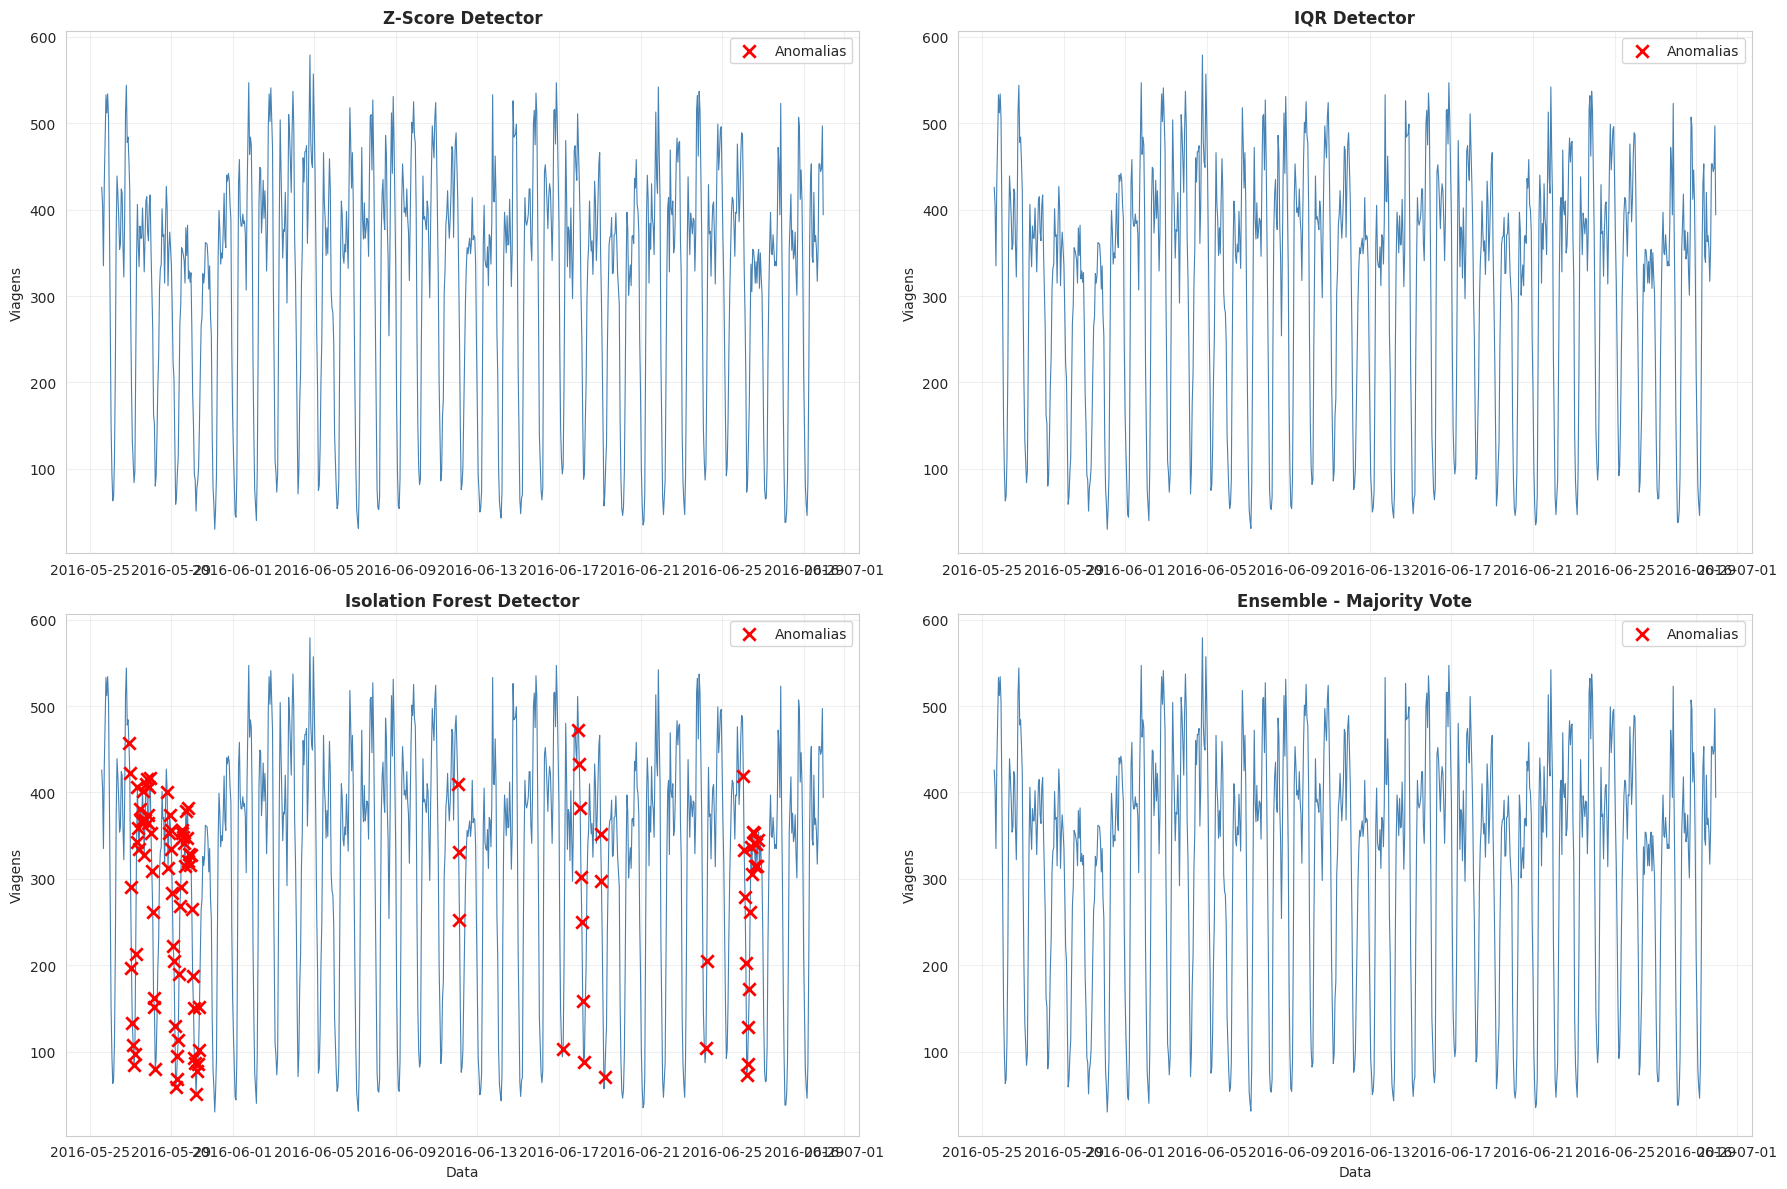

In [13]:
# ## Visualização 1: Comparação de Métodos

print("\nGerando visualizações...")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Série com Z-Score
test_plot = test.iloc[:n_aligned]
anomaly_z = zscore_aligned == 1

axes[0, 0].plot(test_plot['timestamp'], test_plot['value'], linewidth=0.8, color='steelblue')
axes[0, 0].scatter(test_plot[anomaly_z]['timestamp'], test_plot[anomaly_z]['value'],
                  color='red', s=80, marker='x', linewidth=2, label='Anomalias', zorder=5)
axes[0, 0].set_title('Z-Score Detector', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Viagens')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Série com IQR
anomaly_iqr = iqr_aligned == 1

axes[0, 1].plot(test_plot['timestamp'], test_plot['value'], linewidth=0.8, color='steelblue')
axes[0, 1].scatter(test_plot[anomaly_iqr]['timestamp'], test_plot[anomaly_iqr]['value'],
                  color='red', s=80, marker='x', linewidth=2, label='Anomalias', zorder=5)
axes[0, 1].set_title('IQR Detector', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Viagens')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Série com Isolation Forest
anomaly_iso = iso_aligned == 1

axes[1, 0].plot(test_plot['timestamp'], test_plot['value'], linewidth=0.8, color='steelblue')
axes[1, 0].scatter(test_plot[anomaly_iso]['timestamp'], test_plot[anomaly_iso]['value'],
                  color='red', s=80, marker='x', linewidth=2, label='Anomalias', zorder=5)
axes[1, 0].set_title('Isolation Forest Detector', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Viagens')
axes[1, 0].set_xlabel('Data')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Ensemble Majority Vote
anomaly_maj = majority_vote == 1

axes[1, 1].plot(test_plot['timestamp'], test_plot['value'], linewidth=0.8, color='steelblue')
axes[1, 1].scatter(test_plot[anomaly_maj]['timestamp'], test_plot[anomaly_maj]['value'],
                  color='red', s=80, marker='x', linewidth=2, label='Anomalias', zorder=5)
axes[1, 1].set_title('Ensemble - Majority Vote', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Viagens')
axes[1, 1].set_xlabel('Data')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/plots/07_pipeline_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/07_pipeline_comparison.png")
plt.show()

✓ Salvo: outputs/plots/07_consensus_heatmap.png


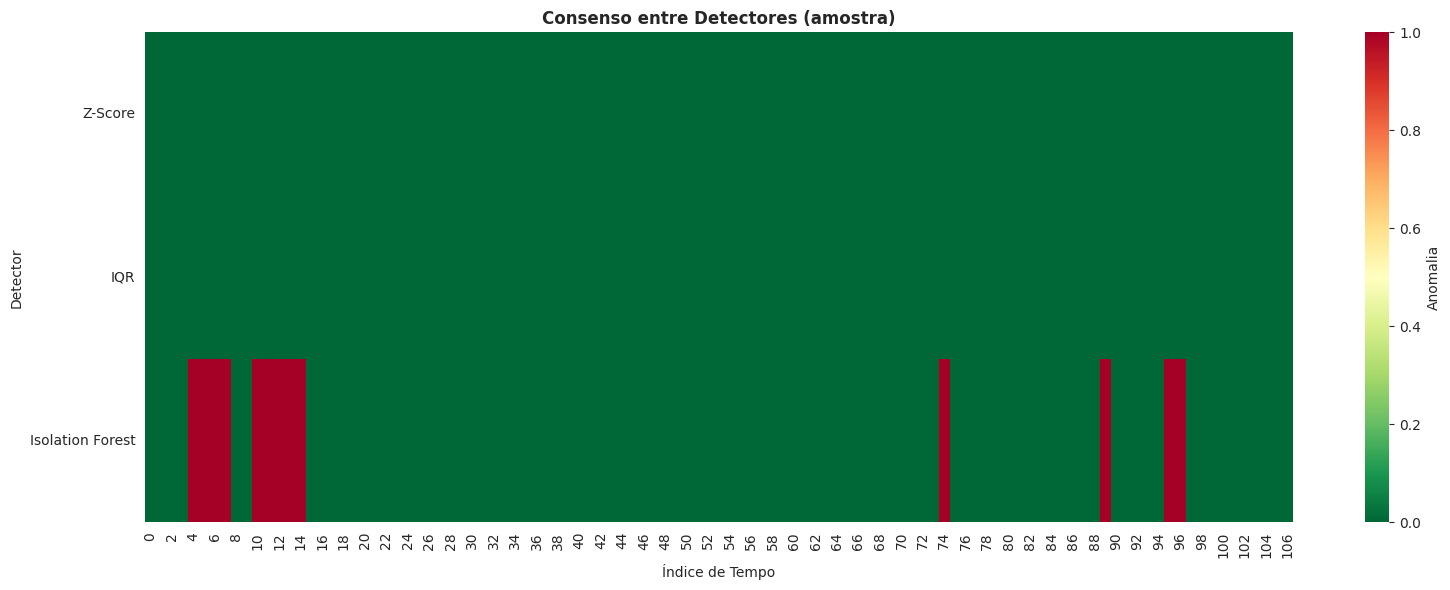

In [14]:
# ## Visualização 2: Heatmap de Consenso

fig, ax = plt.subplots(figsize=(16, 6))

# Amostra cada 100 pontos
sample_idx = np.arange(0, len(all_preds), max(1, len(all_preds)//100))
heatmap_sample = all_preds[sample_idx]

sns.heatmap(heatmap_sample.T, cmap='RdYlGn_r', cbar_kws={'label': 'Anomalia'}, ax=ax)
ax.set_title('Consenso entre Detectores (amostra)', fontsize=12, fontweight='bold')
ax.set_xlabel('Índice de Tempo')
ax.set_ylabel('Detector')
ax.set_yticklabels(['Z-Score', 'IQR', 'Isolation Forest'], rotation=0)

plt.tight_layout()
plt.savefig('outputs/plots/07_consensus_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/07_consensus_heatmap.png")
plt.show()

In [15]:
# ## Salvar Resultados

results = test_plot.copy()
results['zscore'] = zscore_aligned
results['iqr'] = iqr_aligned
results['isolation_forest'] = iso_aligned
results['majority_vote'] = majority_vote
results['consensus'] = consensus

results.to_csv('outputs/reports/day7_pipeline_results.csv', index=False)
print("✓ Salvo: outputs/reports/day7_pipeline_results.csv")


✓ Salvo: outputs/reports/day7_pipeline_results.csv


In [16]:
# ## Salvar Pipeline

print("\n" + "=" * 70)
print("SALVANDO PIPELINE")
print("=" * 70)

pipeline_info = {
    'timestamp': datetime.now().isoformat(),
    'detectors': {
        'zscore': {'name': 'Z-Score', 'threshold': zscore_det.threshold},
        'iqr': {'name': 'IQR', 'lower': iqr_det.lower_bound, 'upper': iqr_det.upper_bound},
        'isolation_forest': {'name': 'Isolation Forest', 'contamination': iso_det.contamination}
    },
    'ensemble': {
        'majority_vote_threshold': 2,
        'consensus_threshold': 3
    },
    'performance': {
        'total_anomalies_majority': int(majority_vote.sum()),
        'total_anomalies_consensus': int(consensus.sum()),
        'total_points': len(test_plot)
    }
}

with open('outputs/models/pipeline_config.pkl', 'wb') as f:
    pickle.dump(pipeline_info, f)

print("\n✓ Pipeline configuração salva: outputs/models/pipeline_config.pkl")



SALVANDO PIPELINE

✓ Pipeline configuração salva: outputs/models/pipeline_config.pkl


In [17]:
# ## Documentação

print("\n" + "=" * 70)
print("DOCUMENTAÇÃO DO PIPELINE")
print("=" * 70)

doc = f"""
# PIPELINE DE DETECÇÃO DE ANOMALIAS - DIA 7

## Resumo
Pipeline completo para detecção de anomalias em séries temporais (NYC Taxi Demand).

## Detectores Implementados
1. **Z-Score**: Detecta pontos > 3 desvios padrão
2. **IQR**: Usa quartis para definir limites
3. **Isolation Forest**: Baseado em árvores aleatórias

## Estratégias de Ensemble
- **Majority Vote (>= 2 de 3)**: Balance entre sensibilidade e especificidade
- **Consenso (3 de 3)**: Alta confiança, menos false positives

## Resultados
- Majority Vote: {majority_vote.sum()} anomalias ({100*majority_vote.sum()/len(majority_vote):.2f}%)
- Consenso: {consensus.sum()} anomalias ({100*consensus.sum()/len(consensus):.2f}%)

## Arquivos Gerados
- outputs/reports/day7_detectors_summary.csv
- outputs/reports/day7_pipeline_results.csv
- outputs/models/pipeline_config.pkl
- outputs/plots/07_pipeline_comparison.png
- outputs/plots/07_consensus_heatmap.png

## Como Usar
```python
# Carregar pipeline
import pickle

with open('outputs/models/pipeline_config.pkl', 'rb') as f:
    pipeline_config = pickle.load(f)

# Ver configuração
print(pipeline_config)
```

## Próximos Passos
- Dia 8: Deploy e Extensões
"""

with open('outputs/reports/PIPELINE_DOCUMENTATION.md', 'w') as f:
    f.write(doc)

print("\n✓ Documentação salva: outputs/reports/PIPELINE_DOCUMENTATION.md")


DOCUMENTAÇÃO DO PIPELINE

✓ Documentação salva: outputs/reports/PIPELINE_DOCUMENTATION.md


In [18]:
# ## Resumo Final

print("\n" + "=" * 70)
print("RESUMO DO DIA 7")
print("=" * 70)

print(f"""
✅ PIPELINE COMPLETO CRIADO

📊 Detectores Treinados: 3
   • Z-Score
   • IQR
   • Isolation Forest

🔄 Estratégias de Ensemble: 2
   • Majority Vote: {majority_vote.sum()} anomalias
   • Consenso: {consensus.sum()} anomalias

📁 Arquivos Salvos:
   • Configuração do Pipeline
   • Resultados (CSV)
   • Documentação (MD)
   • Gráficos (PNG)

🎯 Próximos Passos:
   • Dia 8: Deploy em Produção
   • Adicionar mais detectores
   • Implementar alertas em tempo real
""")

print("=" * 70)
print("✓ DIA 7 CONCLUÍDO!")
print("=" * 70)


RESUMO DO DIA 7

✅ PIPELINE COMPLETO CRIADO

📊 Detectores Treinados: 3
   • Z-Score
   • IQR
   • Isolation Forest

🔄 Estratégias de Ensemble: 2
   • Majority Vote: 0 anomalias
   • Consenso: 0 anomalias

📁 Arquivos Salvos:
   • Configuração do Pipeline
   • Resultados (CSV)
   • Documentação (MD)
   • Gráficos (PNG)

🎯 Próximos Passos:
   • Dia 8: Deploy em Produção
   • Adicionar mais detectores
   • Implementar alertas em tempo real

✓ DIA 7 CONCLUÍDO!
